<a href="https://colab.research.google.com/github/Jvlia17/rodents-classification/blob/main/Rosegador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ten kod jest poświęcony kodowaniu w ramach pracy magisterskiej skupionej na opracowywaniu niestandardowego zestawu danych do rozpoznawania gryzoni przy użyciu sztucznej inteligencji. W jego ramach wykorzystuje się najnowocześniejsze technologie, różnorodne metody bilansowania danych, dostrojenie hiperparametrów oraz transfer learning w celu poprawy odporności i efektywności modelu.

Github: https://github.com/Jvlia17/rodents-classification

# **0. Pobranie bibliotek**

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns
import PIL.Image as Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-03-18 12:29:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-18 12:29:53 (55.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# **1. Pobranie danych**

In [3]:
# Usuwanie istniejących folderów
!rm -rf sample_data

# Pobranie danych i wyodrębnienie ich
!wget https://www.dropbox.com/scl/fi/9kn0v6wrzu5u1i281k191/Rosegador.zip?rlkey=56u1mquuztup2db9diybpfy9c&dl=0

--2024-03-18 12:29:53--  https://www.dropbox.com/scl/fi/9kn0v6wrzu5u1i281k191/Rosegador.zip?rlkey=56u1mquuztup2db9diybpfy9c
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc352b7f9b20a4c09fe108f63159.dl.dropboxusercontent.com/cd/0/inline/CPVbNt0rYACUoXNsg732GUwDuRYwSjgws2Pkg-bH1Eg3fMp0gV4a_432vBrniy1cr06xTLCToA1dv_raGkExnE911D4Kigkx32LKlccRa_R6nWb4g8QfuJA9CdxvKBrtNORXxuauqE0jKW5lHTKw-HM9/file# [following]
--2024-03-18 12:29:54--  https://uc352b7f9b20a4c09fe108f63159.dl.dropboxusercontent.com/cd/0/inline/CPVbNt0rYACUoXNsg732GUwDuRYwSjgws2Pkg-bH1Eg3fMp0gV4a_432vBrniy1cr06xTLCToA1dv_raGkExnE911D4Kigkx32LKlccRa_R6nWb4g8QfuJA9CdxvKBrtNORXxuauqE0jKW5lHTKw-HM9/file
Resolving uc352b7f9b20a4c09fe108f63159.dl.dropboxusercontent.com (uc352b7f9b20a4c09fe108f63159.dl.dropboxusercontent.com)... 162.125.2.15, 2620:

In [4]:
!unzip /content/Rosegador.zip?rlkey=56u1mquuztup2db9diybpfy9c

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Capybara/cap (256).jpg  
  inflating: Dataset/Capybara/cap (2560).jpg  
  inflating: Dataset/Capybara/cap (2561).jpg  
  inflating: Dataset/Capybara/cap (2562).jpg  
  inflating: Dataset/Capybara/cap (2563).jpg  
  inflating: Dataset/Capybara/cap (2564).jpg  
  inflating: Dataset/Capybara/cap (2565).jpg  
  inflating: Dataset/Capybara/cap (2566).jpg  
  inflating: Dataset/Capybara/cap (2567).jpg  
  inflating: Dataset/Capybara/cap (2568).jpg  
  inflating: Dataset/Capybara/cap (2569).jpg  
  inflating: Dataset/Capybara/cap (257).jpg  
  inflating: Dataset/Capybara/cap (2570).jpg  
  inflating: Dataset/Capybara/cap (2571).jpg  
  inflating: Dataset/Capybara/cap (2572).jpg  
  inflating: Dataset/Capybara/cap (2573).jpg  
  inflating: Dataset/Capybara/cap (2574).jpg  
  inflating: Dataset/Capybara/cap (2575).jpg  
  inflating: Dataset/Capybara/cap (2576).jpg  
  inflating: Dataset/Capybara/cap (2577).jpg  
  inflating

# **2. Sprawdzenie danych**

In [5]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/content/Dataset"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Rat', 222), ('Chinchilla', 338), ('Mouse', 248), ('Hamster', 1361), ('Capybara', 3040), ('Guinea Pig', 1520)])

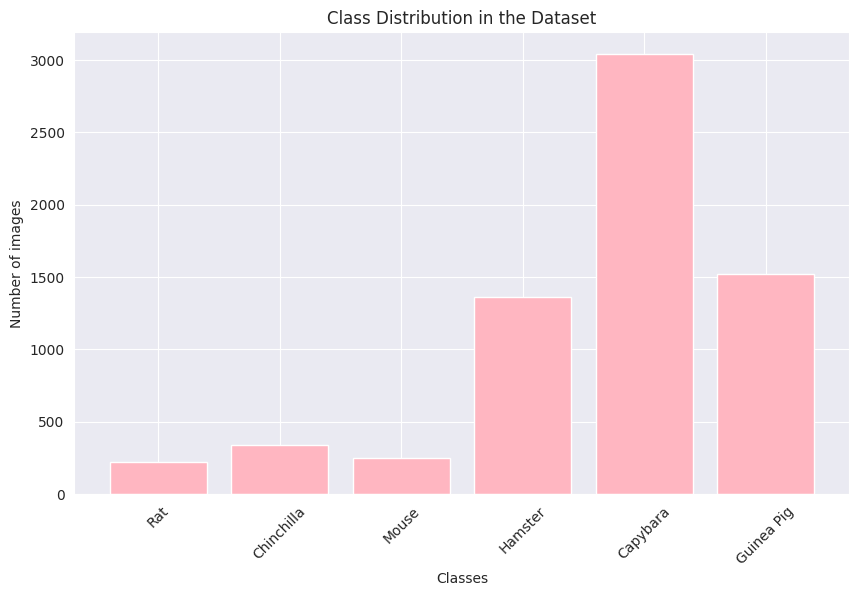

In [6]:
# Pokazanie na wykresie słupkowym rozkad liczebności klas

data_dir = '/content/Dataset'

# Zliczanie obrazów w każdej klasie
class_counts = {}
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Tworzenie wykresu słupkowego
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightpink')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()

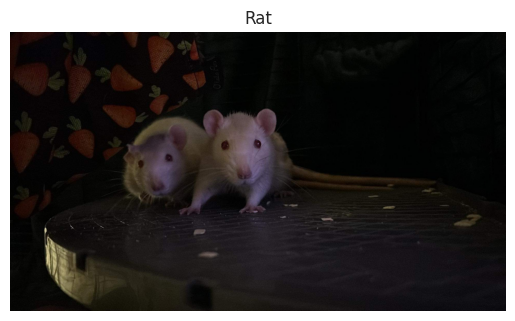

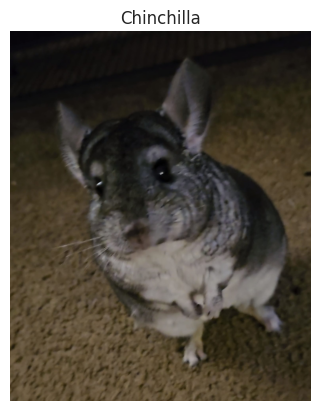

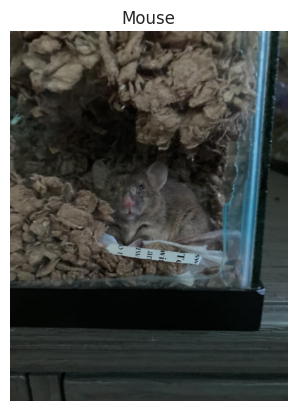

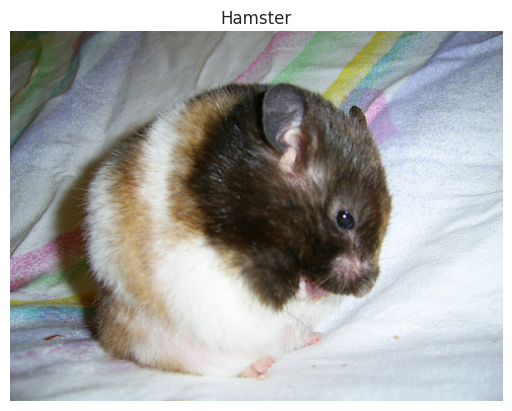

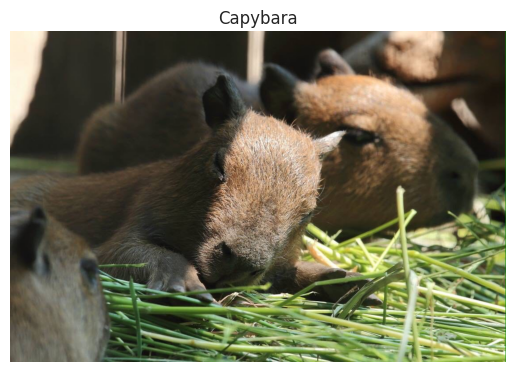

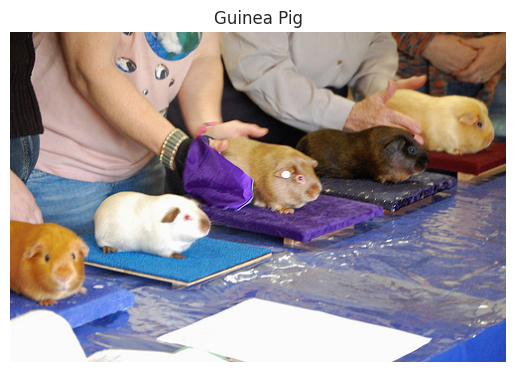

In [7]:
# Wyświetlenie randomowego obrazu z każdego folderu

data_dir = '/content/Dataset'

# Pobierz listę folderów w głównym katalogu
folders = os.listdir(data_dir)

# Iteruj po każdym folderze i wyświetl losowy obraz
for folder in folders:

    # Utwórz pełną ścieżkę do folderu
    folder_path = os.path.join(data_dir, folder)

    # Pobierz listę plików w folderze
    files = os.listdir(folder_path)

    # Wybierz losowy plik z folderu
    random_file = random.choice(files)

    # Utwórz pełną ścieżkę do losowego pliku
    file_path = os.path.join(folder_path, random_file)

    # Wczytaj obraz i wyświetl go
    image = Image.open(file_path)
    plt.imshow(image)
    plt.title(f"{folder}")
    plt.axis("off")
    plt.show()

# **3. Przygotowanie danych**

In [8]:
batch_size = 32
target_size = (224, 224)
dataset = "/content/Dataset"

In [9]:
# Tworzy obiekt Path, dzięki któremu będziemy łatwiej operowali na ścieżkach plików
image_dir = Path(dataset)

# Używa metody glob do wyszukiwania plików o danych rozszerzeniach, wyniki są łączone w jedną listę
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.JPEG'))

# Dzięki temu dla każdego pliku mamy etykietę, będącą nazwą katalogu
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Konwertuje listę na serię Pandas, wszystkie ścieżki są typu String
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Łączy filepaths i labels w jedną ramkę danych Pandas: śieżka pliku i etykieta
image_df = pd.concat([filepaths, labels], axis=1)

In [10]:
# Dzielimy dane: train_df ma 80% oryginalnych danych, test_df ma 20%
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

# **4. Balansowanie zbioru**

## 4.1 Undersampling

In [ ]:
class_counts = train_df['Label'].value_counts()

# Redukujemy do liczby próbek klasy najmniej licznej
min_class_count = class_counts.min()

# Przeprowadzenie undersamplingu
sampled_dfs = []
for label in train_df['Label'].unique():

    # Wybieramy próbki z danej klasy
    class_df = train_df[train_df['Label'] == label]

    # Losowo redukujemy liczbę próbek do wartości min_class_count
    sampled_dfs.append(class_df.sample(n=min_class_count, random_state=42))

# Łączenie zredukowanych DataFrame'ów z każdej klasy
train_df = pd.concat(sampled_dfs).reset_index(drop=True)

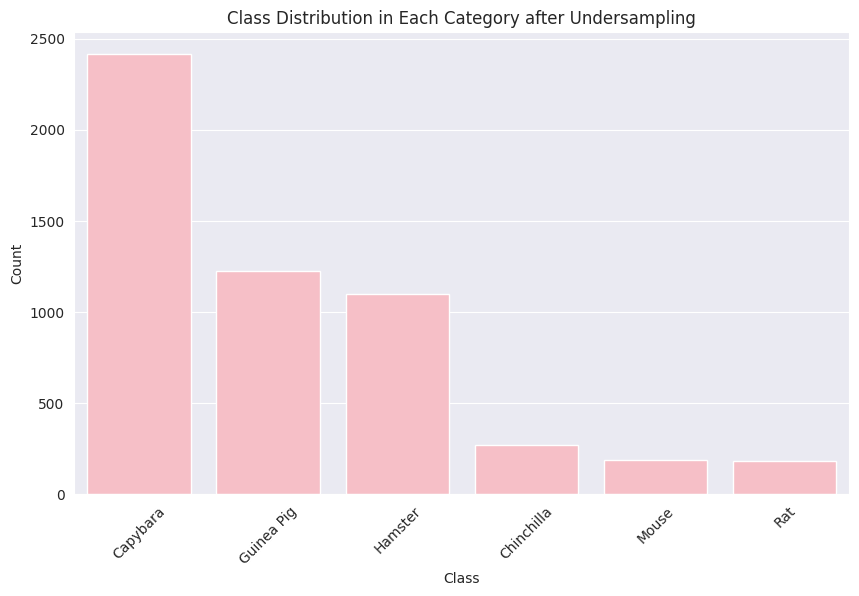

In [ ]:
# Wykres rozkładu klas
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, color='lightpink')
plt.title('Class Distribution in Each Category after Undersampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## 4.2 Oversampling

In [ ]:
class_counts = train_df['Label'].value_counts()

# Zwiększamy liczbę próbek do klasy najbardziej licznej
max_class_count = class_counts.max()

# Przeprowadzenie oversamplingu
oversampled_dfs = []
for label in train_df['Label'].unique():

    # Wybieramy próbki z danej klasy
    class_df = train_df[train_df['Label'] == label]

    # Powielamy próbki do osiągnięcia max_class_count, jeśli jest ich za mało
    if len(class_df) < max_class_count:

        # Powielamy próbki i ewentualnie dodajemy lekką augmentację
        class_df_oversampled = class_df.sample(n=max_class_count, replace=True, random_state=42)
        oversampled_dfs.append(class_df_oversampled)
    else:
        oversampled_dfs.append(class_df)

# Łączenie powielonych DataFrame'ów z każdej klasy
train_df = pd.concat(oversampled_dfs).reset_index(drop=True)

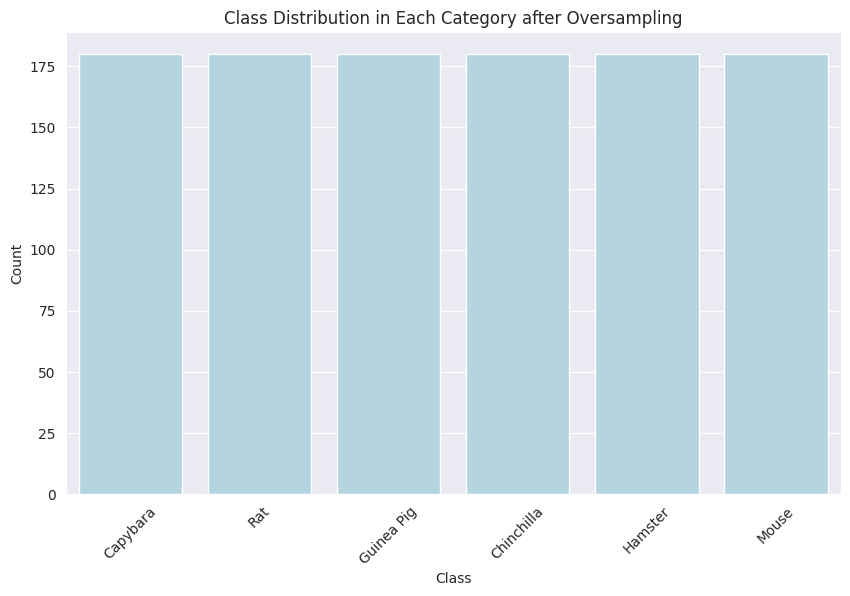

In [ ]:
# Wykres rozkładu klas
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, color='lightblue')
plt.title('Class Distribution in Each Category after Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 4.3 Class weighting

Błędy popełniane na próbkach z mniej licznych klas mają większy wpływ

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Konwersja etykiet na wartości numeryczne, jeśli są one kategorialne
labels = pd.factorize(train_df['Label'])[0]

# Uzyskanie unikalnych klas i odpowiadających im wag
classes = np.unique(labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

class_weights = dict(zip(classes, weights))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

labels = train_df['Label']
classes = np.unique(labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
class_weights = dict(zip(np.arange(len(classes)), weights))

# **5. Przygotowanie danych do modelu**

In [ ]:
# Uniwersalny
"""
# Generator danych dla treningu
train_generator = ImageDataGenerator(
    rescale=1./255,  # Normalizacja pikseli do zakresu [0, 1]
    validation_split=0.2  # Opcjonalnie: wydzielenie części danych treningowych na walidację
)

# Generator danych dla testowania
test_generator = ImageDataGenerator(
    rescale=1./255
)
"""

# EfficientNet
"""
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)
"""

# VGG16

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)


# ResNet50
"""
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)
"""

# DenseNet
"""
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)
"""

# MobileNet
"""
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)
"""

'\ntrain_generator = ImageDataGenerator(\n    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,\n    validation_split=0.2\n)\n\ntest_generator = ImageDataGenerator(\n    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input\n)\n'

In [ ]:
# Generatory do iteracyjnego ładowania i przetwarzania obrazów w batchach podczas treningu, walidacji i testowania modelu

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 864 validated image filenames belonging to 6 classes.
Found 216 validated image filenames belonging to 6 classes.
Found 1345 validated image filenames belonging to 6 classes.


In [ ]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['Capybara', 'Chinchilla', 'Guinea Pig', 'Hamster', 'Mouse', 'Rat']


# **6 Augmentacja danych**

In [ ]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# **7. Wybranie modelu**

## 7.1 VGG16

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Set the model to be non-trainable
pretrained_model.trainable = False

## 7.2 ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the pretrained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Set the model to be non-trainable
pretrained_model.trainable = False

NameError: name 'tf' is not defined

## 7.3 AlexNet

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')
])

## 7.4 EfficientNet

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Set the model to be non-trainable
pretrained_model.trainable = False

## 7.5 DenseNet

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load the pretrained DenseNet121 model
pretrained_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Set the model to be non-trainable
pretrained_model.trainable = False


## 7.6 MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Set the model to be non-trainable
pretrained_model.trainable = False

# **8. Trenowanie modelu**

In [ ]:
# Create checkpoint callback
checkpoint_path = "./bestmodel.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input  # Pobiera warstwę wejściową wstępnie wytrenowanego modelu
x = augment(inputs) # Augmentacja danych

# Nasz model
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Dla wersji z wagami
# model = Model(inputs=inputs, outputs=outputs, class_weight=class_weights)

model.compile(
    optimizer=Adam(0.0001), # Hiperparametr do obczajenia
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "rodents_classification"),
        checkpoint_callback,
    ]
)

# history = model.fit(
#     train_images,
#     steps_per_epoch=len(train_images),
#     validation_data=val_images,
#     validation_steps=len(val_images),
#     epochs=100,
#     class_weight=class_weights,
#     callbacks=[
#         early_stopping,
#         create_tensorboard_callback("training_logs",
#                                     "rodents_classification"),
#         checkpoint_callback,
#     ]
# )

Saving TensorBoard log files to: training_logs/rodents_classification/20240312-210407
Epoch 1/100
27/27 [==============================] - 21s 712ms/step - loss: 49.2399 - accuracy: 0.1852 - val_loss: 39.6410 - val_accuracy: 0.0093
Epoch 2/100
27/27 [==============================] - 13s 494ms/step - loss: 36.9383 - accuracy: 0.2083 - val_loss: 39.1512 - val_accuracy: 0.0139
Epoch 3/100
27/27 [==============================] - 13s 485ms/step - loss: 30.9665 - accuracy: 0.2315 - val_loss: 34.1224 - val_accuracy: 0.0278
Epoch 4/100
27/27 [==============================] - 13s 485ms/step - loss: 22.2714 - accuracy: 0.2523 - val_loss: 28.5891 - val_accuracy: 0.0139
Epoch 5/100
27/27 [==============================] - 14s 493ms/step - loss: 18.6900 - accuracy: 0.2674 - val_loss: 24.5858 - val_accuracy: 0.0093
Epoch 6/100
27/27 [==============================] - 13s 480ms/step - loss: 15.8219 - accuracy: 0.2998 - val_loss: 20.3601 - val_accuracy: 0.0139
Epoch 7/100
27/27 [===================

In [ ]:
# Zapisanie wag modelu -> nie jest konieczne, bo i tak więcej działam na zapisanym modelu
model.save_weights('models_weights.h5')

# **9. Ewaluacja modelu**

In [ ]:
from keras.models import load_model

# Wczytanie modelu wraz z wagami jeśli go nie ma
# model = load_model("/content/animals_eff.h5")

results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.82235
Test Accuracy: 75.39%


## 9.1 Training vs validation accuracy/loss

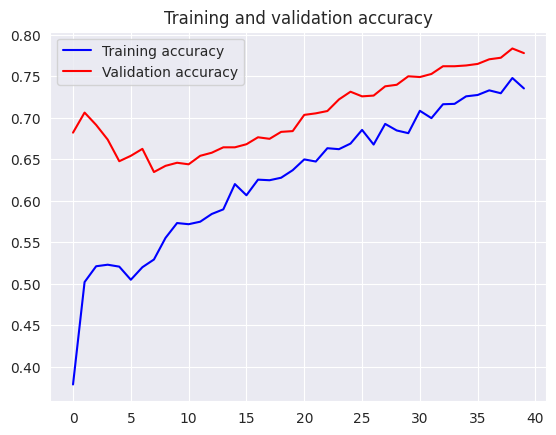

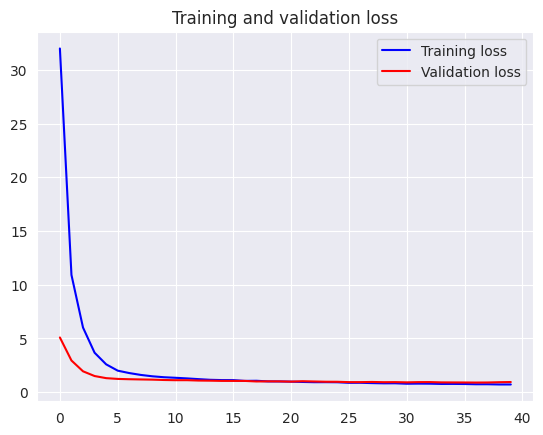

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## 9.2 Predykcje na test data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

43/43 [==============================] - 12s 274ms/step
The first 5 predictions: ['Capybara', 'Capybara', 'Capybara', 'Capybara', 'Capybara']


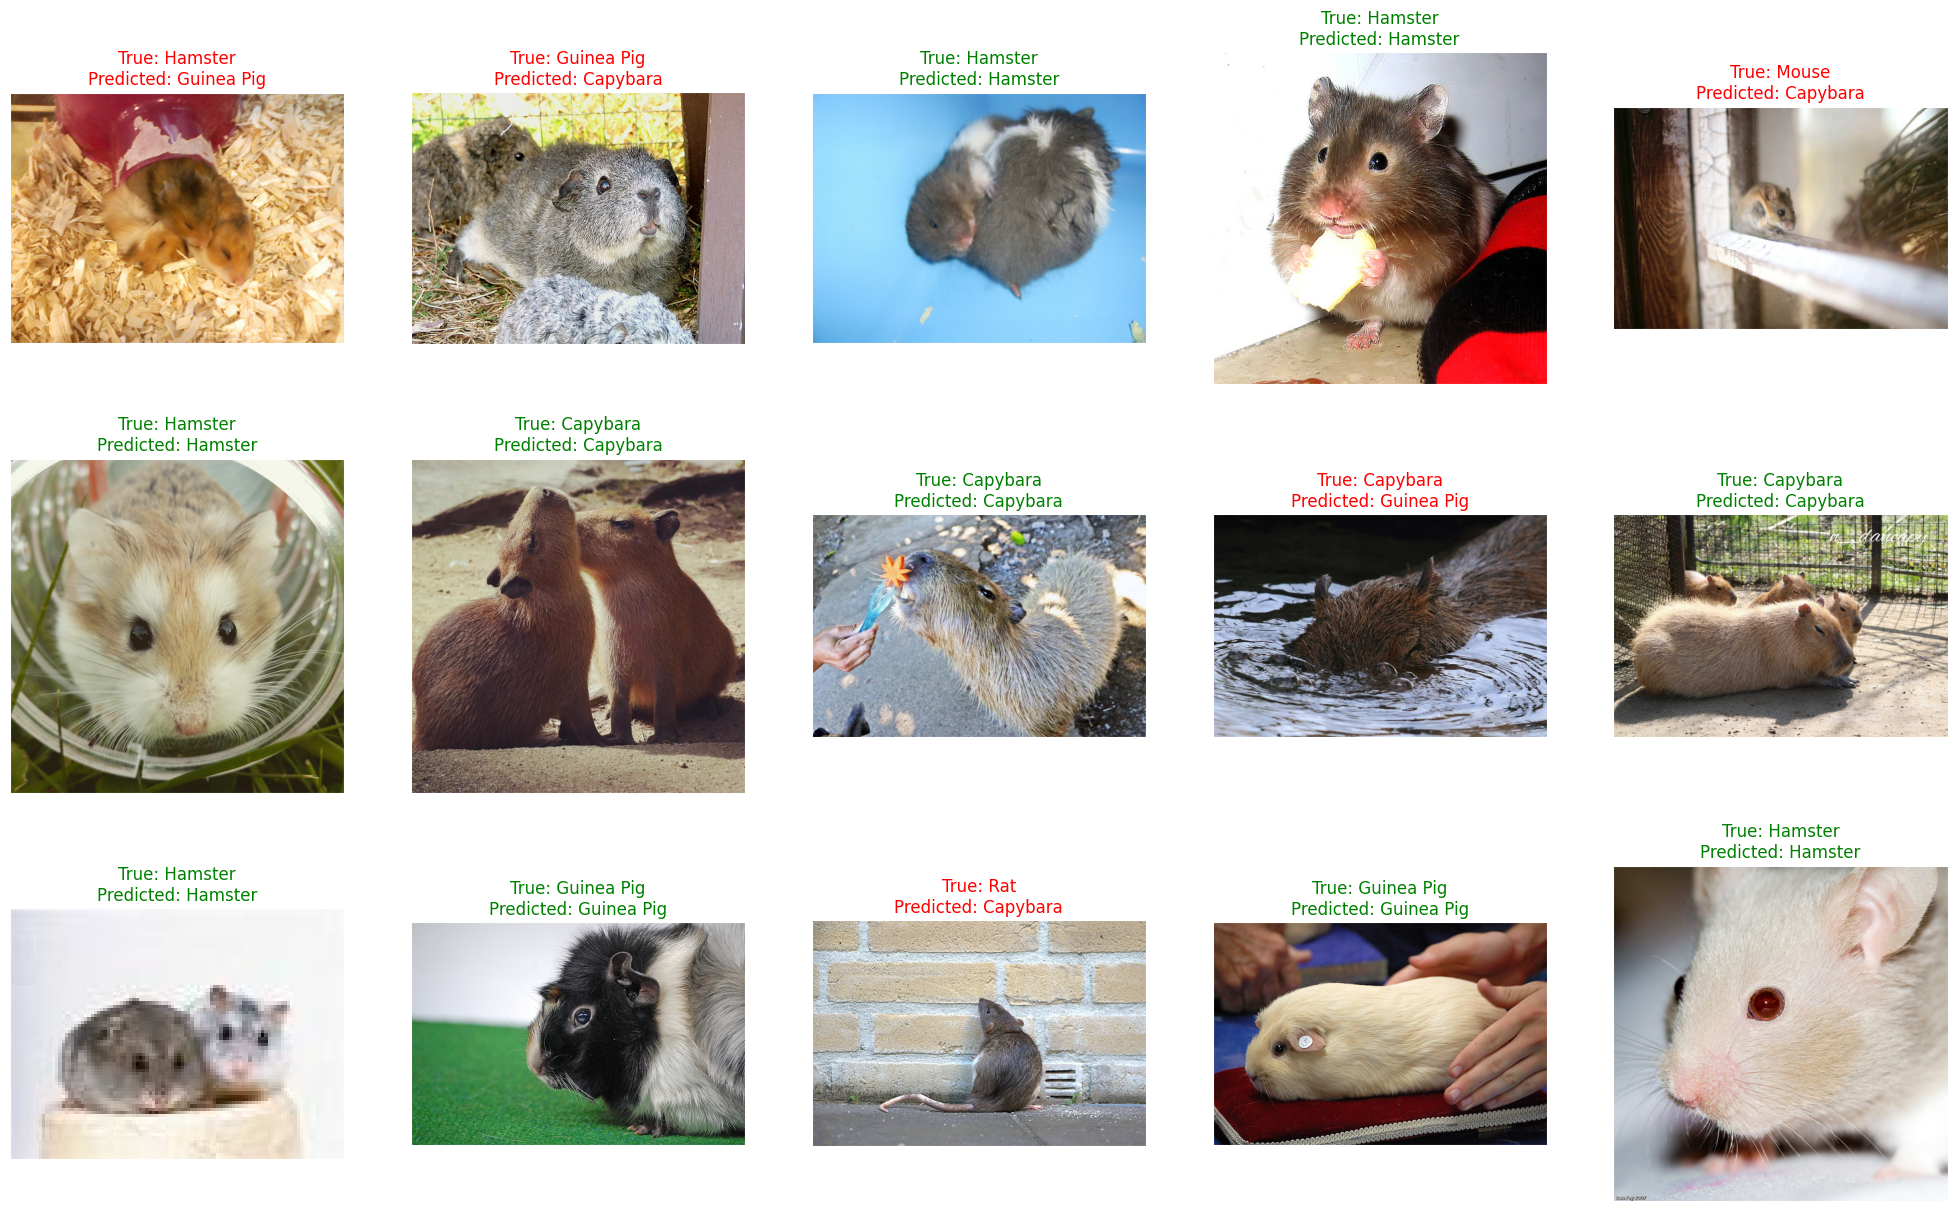

<Figure size 640x480 with 0 Axes>

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## 9.3. Macierz pomyłek

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Capybara       0.94      0.96      0.95       625
  Chinchilla       0.80      0.06      0.11        66
  Guinea Pig       0.80      0.62      0.70       296
     Hamster       0.47      0.87      0.61       255
       Mouse       0.33      0.02      0.03        61
         Rat       0.00      0.00      0.00        42

    accuracy                           0.75      1345
   macro avg       0.56      0.42      0.40      1345
weighted avg       0.76      0.75      0.72      1345



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score      support
Capybara       0.942097  0.963200  0.952532   625.000000
Chinchilla     0.800000  0.060606  0.112676    66.000000
Guinea Pig     0.804348  0.625000  0.703422   296.000000
Hamster        0.474359  0.870588  0.614108   255.000000
Mouse          0.333333  0.016393  0.031250    61.000000
Rat            0.000000  0.000000  0.000000    42.000000
accuracy       0.753903  0.753903  0.753903     0.753903
macro avg      0.559023  0.422631  0.402331  1345.000000
weighted avg   0.759102  0.753903  0.720807  1345.000000

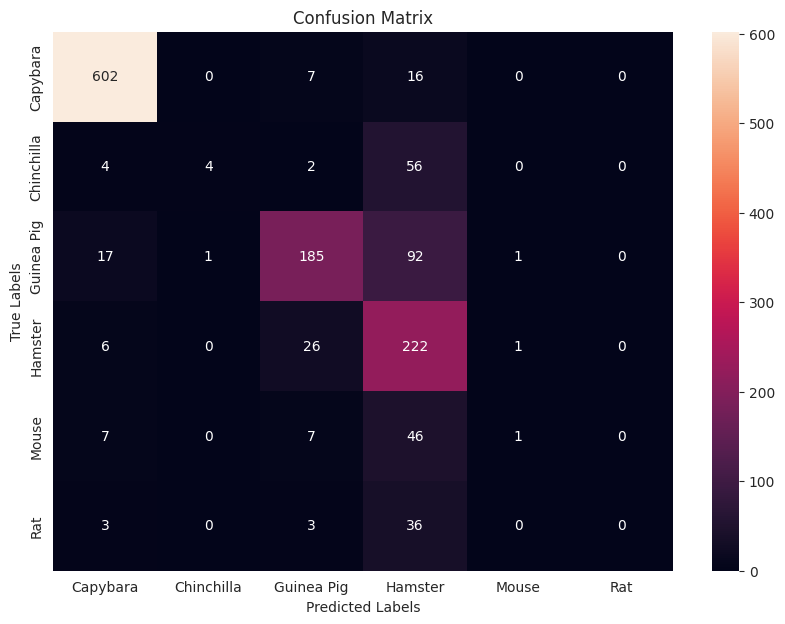

In [ ]:
# Załóżmy, że `y_test` to prawdziwe etykiety, a `pred` to przewidywane etykiety
cm = confusion_matrix(y_test, pred)

# Etykiety dla osi w macierzy pomyłek
labels = list(labels.values())  # Założenie, że `labels` jest słownikiem

# Tworzenie heatmapy z macierzy pomyłek
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()